<a href="https://colab.research.google.com/github/InsightfulAnalyzer/Bank-Customer-Churn-Analysis/blob/main/Bank_customer_churn_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bank customer churn analysis**

**Problem statement:**

- In the rapidly evolving banking sector, customer retention has become a critical concern. Banks are increasingly seeking to understand the factors that influence customer decisions to stay with or leave their banking service provider.
- This project focuses on analyzing a dataset containing various attributes of bank customers to identify key predictors of customer churn.
- By leveraging data analytics, aim to uncover patterns and insights that could help devise strategies to enhance customer retention and reduce churn rates.

# **Data set review & preparation**

In this section we will seek to explore the structure of our data:

1. To understand the input space the data set
2. And to prepare the sets for exploratory and prediction tasks as described.

In [6]:
import numpy as np
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv("Bank-Records.csv")
df.shape

(10000, 18)

The Df has 1000 rows with 18 attributes. We review this further to identify what attributes will be necessary and what data manipulation needs to be carried out before Exploratory analysis and prediction modelling.

In [4]:
# Check columns list and missing values
df.isnull().sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [5]:
# Get unique count for each variable
df.nunique()

RowNumber             10000
CustomerId            10000
Surname                2932
CreditScore             460
Geography                 3
Gender                    2
Age                      70
Tenure                   11
Balance                6382
NumOfProducts             4
HasCrCard                 2
IsActiveMember            2
EstimatedSalary        9999
Exited                    2
Complain                  2
Satisfaction Score        5
Card Type                 4
Point Earned            785
dtype: int64

From the above, we will not require the first 2 attributes as the are specific to a customer. It is borderline with the surname as this would result to profiling so we exclude this as well.


In [9]:
# Drop the columns as explained above
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [11]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


From the above, a couple of question linger:

1. The data appears to be a snapshot as some point in time e.g. the balance is for a given date which leaves a lot of questions:
- What date is it and of what relevance is this date
- Would it be possible to obtain balances over a period of time as opposed to a single date.

2. There are customers who have exited but still have a balance in their account! What would this mean? Could they have exited from a product and not the bank?
3. What does being an active member mean and are there difference degrees to it? Could it be better to provide transaction count both in terms of credits and debits to the account instead?
4. A break down to the products bought into by a customer could provide more information topping listing of product count

For this exercise, we proceed to model without context even though typically having context and better understanding of the data extraction process would give better insight and possibly lead to better and contextual results of the modelling process

In [12]:
# Check variable data types
df.dtypes

CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

In [31]:
# Summary statistics
print(df.describe())

        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

         HasCrCard  IsActiveMember  EstimatedSalary        Exited  \
count  10000.00000    10000.000000     10000.000000  10000.000000   
mean       0.70550        0.515100    100090.239881      0.203800   
std        0.45584        0.499797     57510.492818      0.4028

### **Exploratory Data Analysis**
Here our main interest is to get an understanding as to how the given attributes relate too the 'Exit' status.

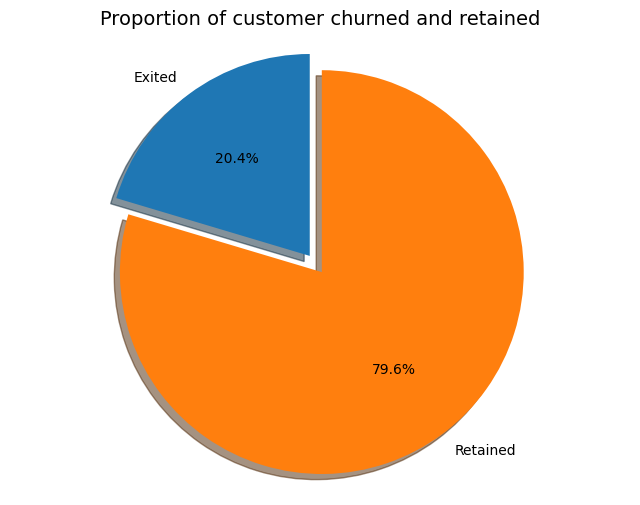

In [15]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 14)
plt.show()

- So about 20% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn. Given 20% is a small number, we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

<Axes: xlabel='IsActiveMember', ylabel='count'>

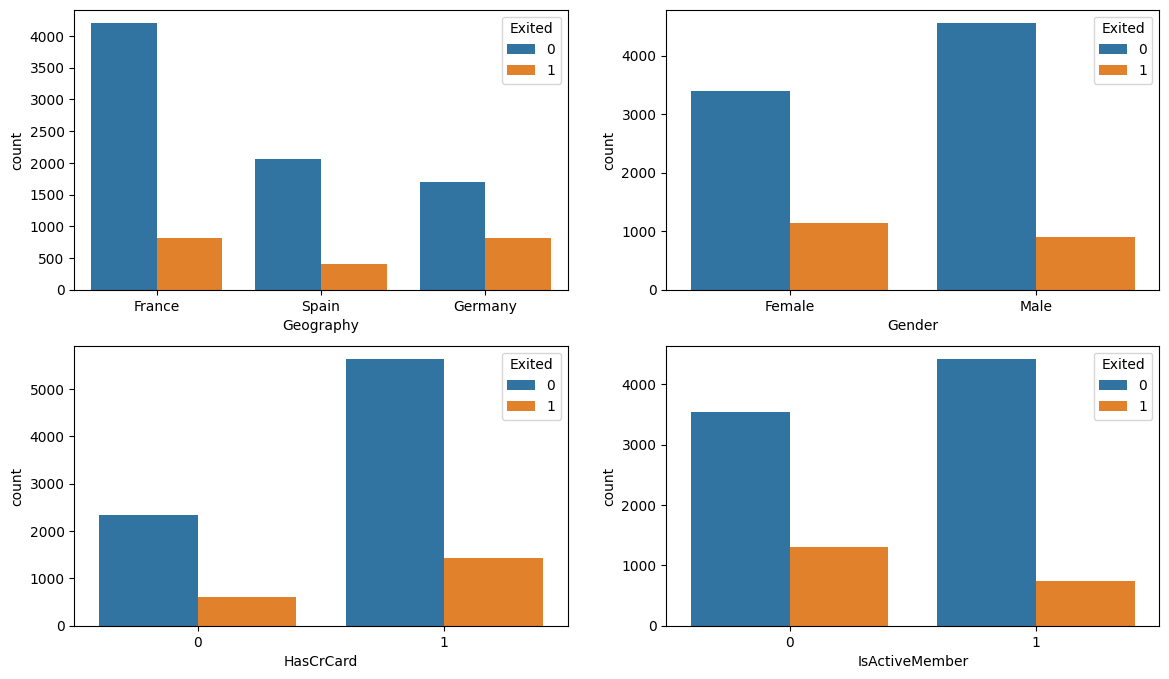

In [20]:
# We first review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(14, 8))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

We note the following:

- Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.
- The proportion of female customers churning is also greater than that of male customers
- Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.
- Unsurprisingly the inactive members have a greater churn. Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn.

<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

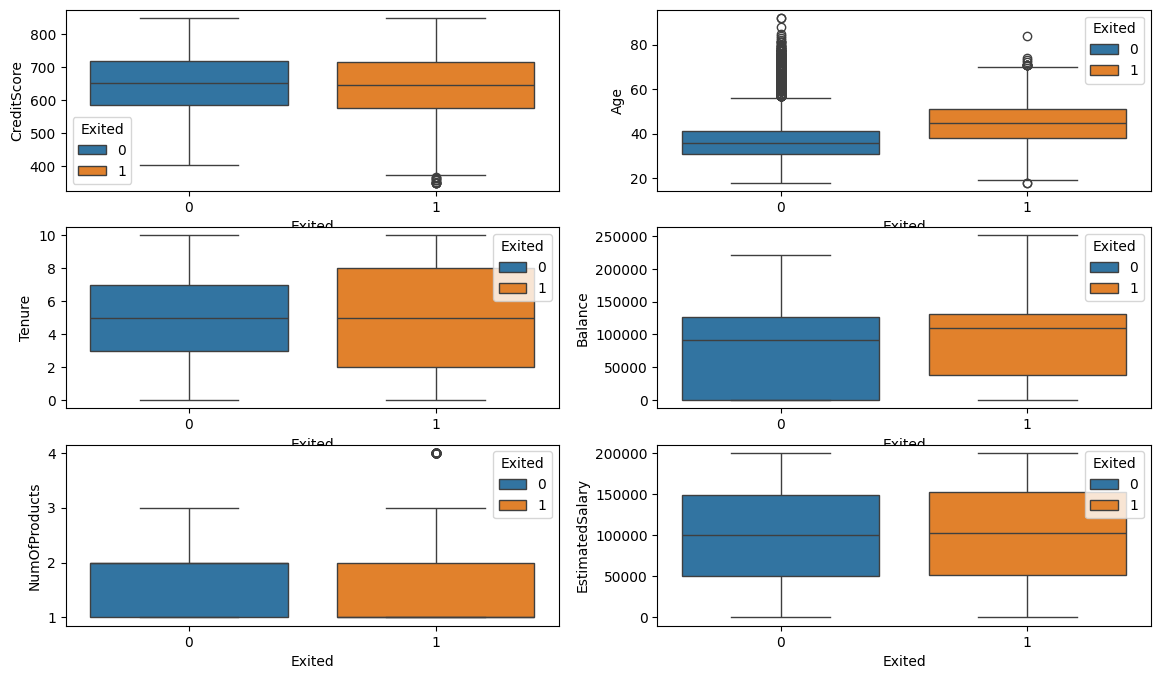

In [19]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(14, 8))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

We note the following:

- There is no significant difference in the credit score distribution between retained and churned customers.
- The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups
- With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.
- Worryingly, the bank is losing customers with significant bank balances which is likely to hit their available capital for lending.
- Neither the product nor the salary has a significant effect on the likelihood to churn.

### **Feature engineering**
We seek to add features that are likely to have an impact on the probability of churning. We first split the train and test sets

In [21]:
# Split Train, test data
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

8000
2000


(-1.0, 5.0)

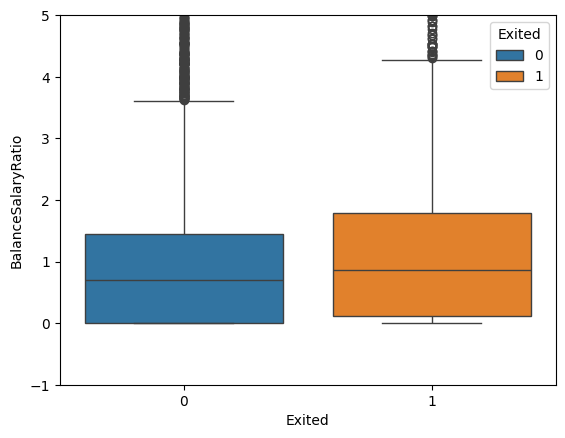

In [22]:
df_train['BalanceSalaryRatio'] = df_train.Balance/df_train.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 5)

- we have seen that the salary has little effect on the chance of a customer churning. However as seen above, the ratio of the bank balance and the estimated salary indicates that customers with a higher balance salary ratio churn more which would be worrying to the bank as this impacts their source of loan capital.

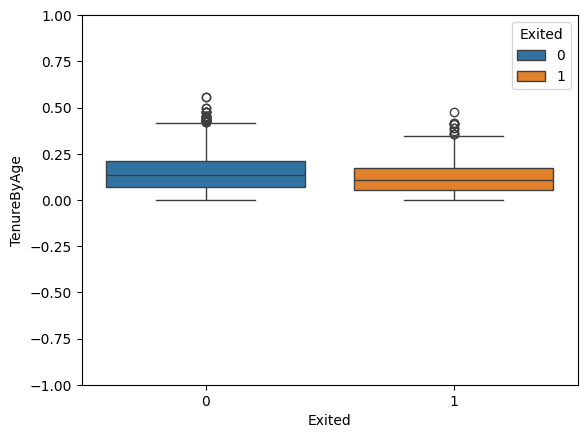

In [23]:
# Given that tenure is a 'function' of age, we introduce a variable aiming to standardize tenure over age:
df_train['TenureByAge'] = df_train.Tenure/(df_train.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 1)
plt.show()

In [24]:
'''Lastly we introduce a variable to capture credit score given age to take into account credit behaviour visavis adult life
:-)'''

df_train['CreditScoreGivenAge'] = df_train.CreditScore/(df_train.Age)

In [25]:
# Resulting Data Frame
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
8159,461,Spain,Female,25,6,0.00,2,1,1,15306.29,0,0,1,PLATINUM,539,0.000000,0.240000,18.440000
6332,619,France,Female,35,4,90413.12,1,1,1,20555.21,0,0,3,DIAMOND,389,4.398550,0.114286,17.685714
8895,699,France,Female,40,8,122038.34,1,1,0,102085.35,0,0,4,DIAMOND,547,1.195454,0.200000,17.475000
5351,558,Germany,Male,41,2,124227.14,1,1,1,111184.67,0,0,3,SILVER,476,1.117305,0.048780,13.609756
4314,638,France,Male,34,5,133501.36,1,0,1,155643.04,0,0,1,GOLD,355,0.857741,0.147059,18.764706


# **Data prep for model fitting**


In [26]:
# Arrange columns by data type for easier manipulation
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df_train = df_train[['Exited'] + continuous_vars + cat_vars]
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,0,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,0,1,France,Male


In [27]:
'''For the one hot variables, we change 0 to -1 so that the models can capture a negative relation
where the attribute in inapplicable instead of 0'''
df_train.loc[df_train.HasCrCard == 0, 'HasCrCard'] = -1
df_train.loc[df_train.IsActiveMember == 0, 'IsActiveMember'] = -1
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,France,Male


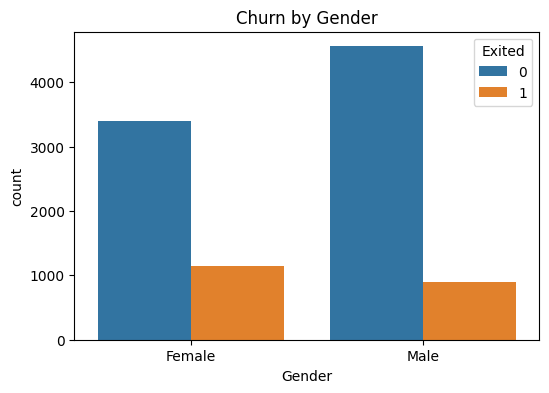

In [34]:
# Churn by gender
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', hue='Exited', data=df)
plt.title('Churn by Gender')
plt.show()

In [37]:
# Churn rate by gender
churn_rate_gender = df.groupby('Gender')['Exited'].mean()
print(churn_rate_gender)

Gender
Female    0.250715
Male      0.164743
Name: Exited, dtype: float64


Based on the provided dataset, the churn rate by gender is as follows:

- Female: 25.1%
- Male: 16.5% This means that the churn rate for female customers is higher (25.1%) compared to male customers (16.5%).

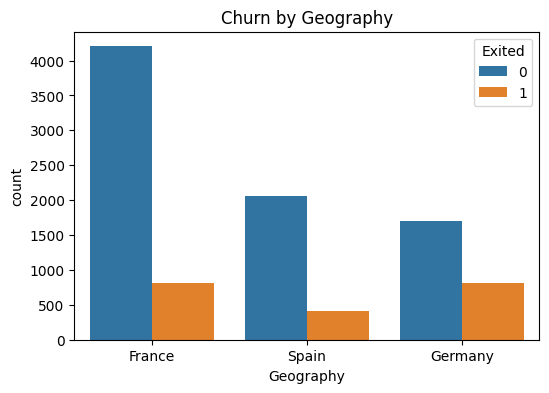

In [35]:
# Churn by geography
plt.figure(figsize=(6, 4))
sns.countplot(x='Geography', hue='Exited', data=df)
plt.title('Churn by Geography')
plt.show()

In [38]:
# Churn rate by geography
churn_rate_geography = df.groupby('Geography')['Exited'].mean()
print(churn_rate_geography)

Geography
France     0.161747
Germany    0.324432
Spain      0.166734
Name: Exited, dtype: float64


Based on the provided dataset, the churn rate by geography is as follows:

- France: 16.2%
- Germany: 32.4%
- Spain: 16.7% This indicates that the churn rate is highest in Germany (32.4%), followed by Spain (16.7%) and France (16.2%).

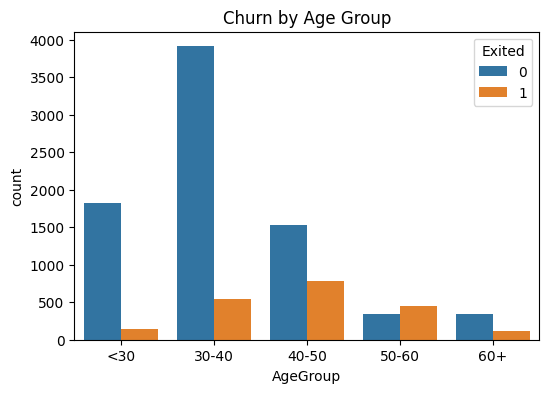

In [40]:
# Churn by age group
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, np.inf], labels=['<30', '30-40', '40-50', '50-60', '60+'])
plt.figure(figsize=(6, 4))
sns.countplot(x='AgeGroup', hue='Exited', data=df)
plt.title('Churn by Age Group')
plt.show()

In [41]:
# Churn rate by age group
churn_rate_age = df.groupby('AgeGroup')['Exited'].mean()
print(churn_rate_age)

AgeGroup
<30      0.075203
30-40    0.121096
40-50    0.339655
50-60    0.562108
60+      0.247845
Name: Exited, dtype: float64


Based on the provided dataset, the churn rate by age group is as follows:

- <30: 7.5%
- 30-40: 12.1%
- 40-50: 33.9%
- 50-60: 56.2%
- 60+: 24.8%

These churn rates indicate that the highest churn rate is observed in the 50-60 age group (56.2%), followed by the 40-50 age group (33.9%). The lowest churn rate is observed in the <30 age group (7.5%).

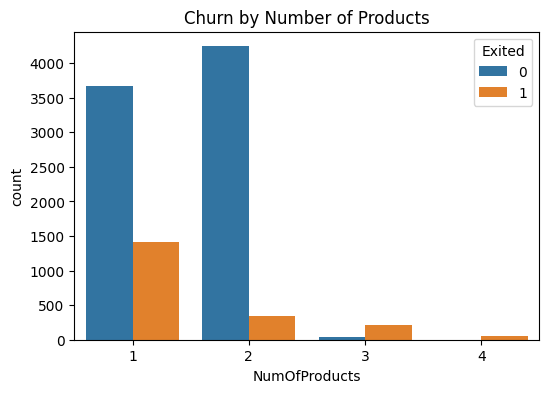

In [43]:
# Churn by Number of Products:
plt.figure(figsize=(6, 4))
sns.countplot(x='NumOfProducts', hue='Exited', data=df)
plt.title('Churn by Number of Products')
plt.show()

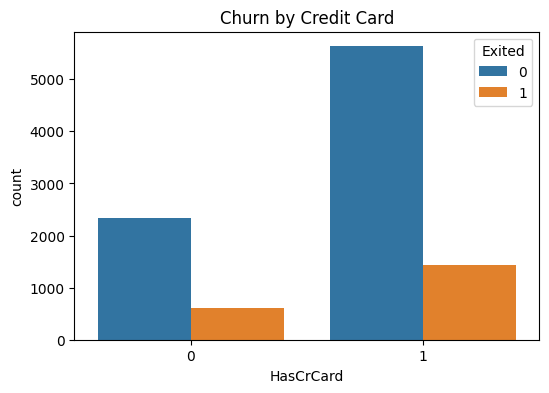

In [45]:
# Churn by Credit Card
plt.figure(figsize=(6, 4))
sns.countplot(x='HasCrCard', hue='Exited', data=df)
plt.title('Churn by Credit Card')
plt.show()

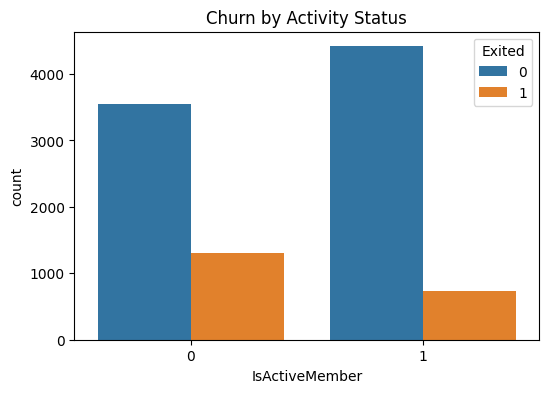

In [46]:
# Churn by Activity Status
plt.figure(figsize=(6, 4))
sns.countplot(x='IsActiveMember', hue='Exited', data=df)
plt.title('Churn by Activity Status')
plt.show()

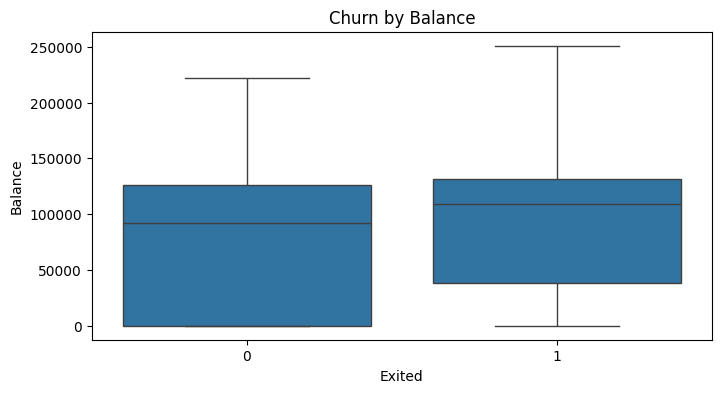

In [47]:
# Churn by Balance:

plt.figure(figsize=(8, 4))
sns.boxplot(x='Exited', y='Balance', data=df)
plt.title('Churn by Balance')
plt.show()

#### Financial Analysis

- Balance vs. Churn: Analyze how customer balance levels correlate with churn rates.
- Credit Card Ownership: Determine if owning a credit card (HasCrCard) impacts customer loyalty.

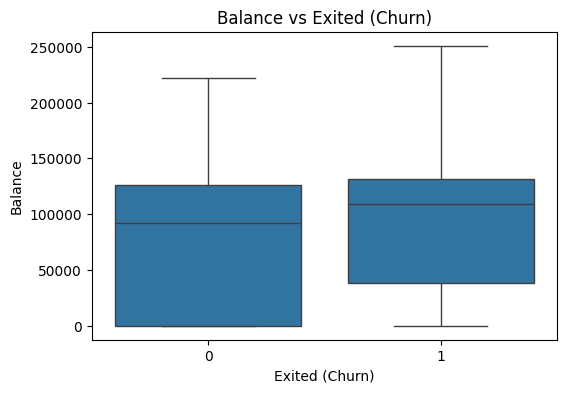

In [71]:
# Boxplot of Balance vs Exited (Churn)

plt.figure(figsize=(6, 4))
sns.boxplot(x='Exited', y='Balance', data=df)
plt.title('Balance vs Exited (Churn)')
plt.xlabel('Exited (Churn)')
plt.ylabel('Balance')
plt.show()

In [72]:
#Perform a t-test to compare the average balances between churned and non-churned customers.

# Separate the data into churned and non-churned groups
churned_balance = df[df['Exited'] == 1]['Balance']
not_churned_balance = df[df['Exited'] == 0]['Balance']

# Perform t-test
t_stat_balance, p_value_balance = ttest_ind(churned_balance, not_churned_balance)
print(f'T-test statistic for balance: {t_stat_balance}')
print(f'P-value for balance: {p_value_balance}')

T-test statistic for balance: 11.940747722508185
P-value for balance: 1.2092076077156017e-32


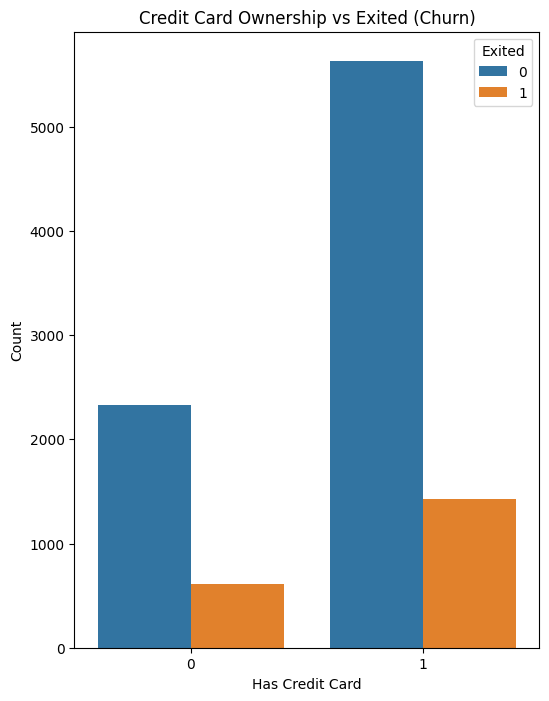

In [73]:
# Credit Card Ownership: Determine If Owning a Credit Card (HasCrCard) Impacts Customer Loyalty

# Countplot of HasCrCard vs Exited (Churn)

plt.figure(figsize=(6, 8))
sns.countplot(x='HasCrCard', hue='Exited', data=df)
plt.title('Credit Card Ownership vs Exited (Churn)')
plt.xlabel('Has Credit Card')
plt.ylabel('Count')
plt.show()

In [75]:
# Create a contingency table
contingency_table_crcard = pd.crosstab(df['HasCrCard'], df['Exited'])

# Perform Chi-Square test
chi2_crcard, p_crcard, dof_crcard, expected_crcard = stats.chi2_contingency(contingency_table_crcard)
print(f'Chi-Square Statistic for credit card ownership: {chi2_crcard}')
print(f'P-value for credit card ownership: {p_crcard}')

Chi-Square Statistic for credit card ownership: 0.4494039375253385
P-value for credit card ownership: 0.5026181509009862


#### **Customer Satisfaction and Feedback**

- Complaint Analysis: Study the impact of having a complaint (Complain) on customer churn.
- Satisfaction and Churn: Explore how the Satisfaction Score relates to churn, especially among those who have filed complaints.

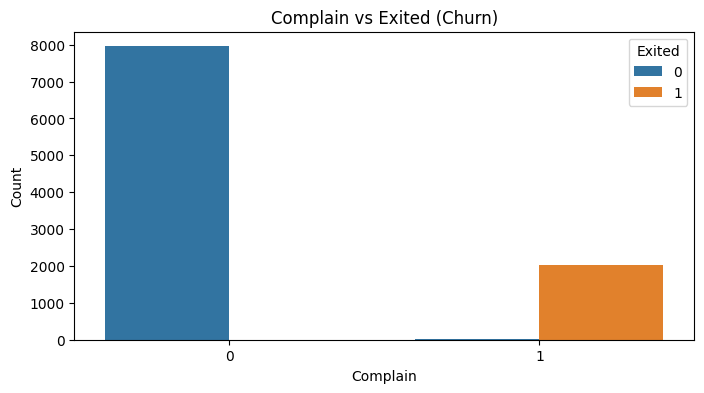

In [66]:
# Countplot of Complain vs Exited (Churn)

plt.figure(figsize=(8, 4))
sns.countplot(x='Complain', hue='Exited', data=df)
plt.title('Complain vs Exited (Churn)')
plt.xlabel('Complain')
plt.ylabel('Count')
plt.show()

In [67]:
# Create a contingency table
contingency_table = pd.crosstab(df['Complain'], df['Exited'])

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f'Chi-Square Statistic: {chi2}')
print(f'P-value: {p}')

Chi-Square Statistic: 9907.907035880155
P-value: 0.0


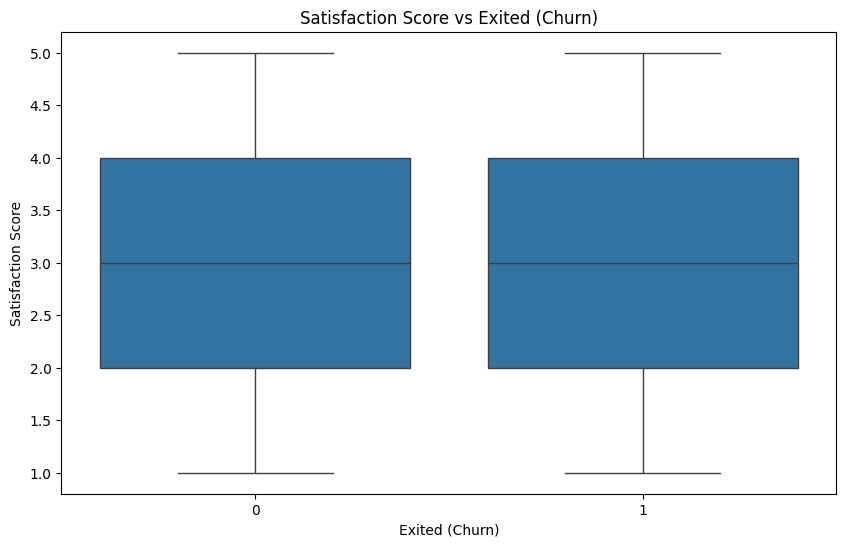

In [69]:
# Boxplot of Satisfaction Score vs Exited (Churn)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Exited', y='Satisfaction Score', data=df)
plt.title('Satisfaction Score vs Exited (Churn)')
plt.xlabel('Exited (Churn)')
plt.ylabel('Satisfaction Score')
plt.show()

**Card Usage Analysis**

- Impact of Card Type on Churn: Examine if different Card Types have different churn rates.
- Loyalty Points Analysis: Investigate whether Points Earned from credit card usage influence customer retention.

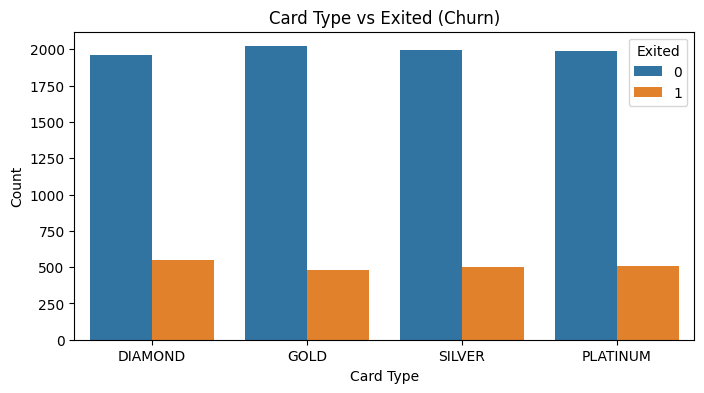

In [60]:
# Visualize the distribution of churn rates across different card types using a bar plot.

# Countplot of Card Type vs Exited (Churn)
plt.figure(figsize=(8, 4))
sns.countplot(x='Card Type', hue='Exited', data=df)
plt.title('Card Type vs Exited (Churn)')
plt.xlabel('Card Type')
plt.ylabel('Count')
plt.show()

In [61]:
# Statistical Analysis
# Perform a Chi-Square test to determine if there is a significant association between card type and churn.

import scipy.stats as stats

# Create a contingency table
contingency_table = pd.crosstab(df['Card Type'], df['Exited'])

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f'Chi-Square Statistic: {chi2}')
print(f'P-value: {p}')

Chi-Square Statistic: 5.053223027060927
P-value: 0.16794112067810177


A low p-value (typically < 0.05) indicates a significant association between card type and churn.

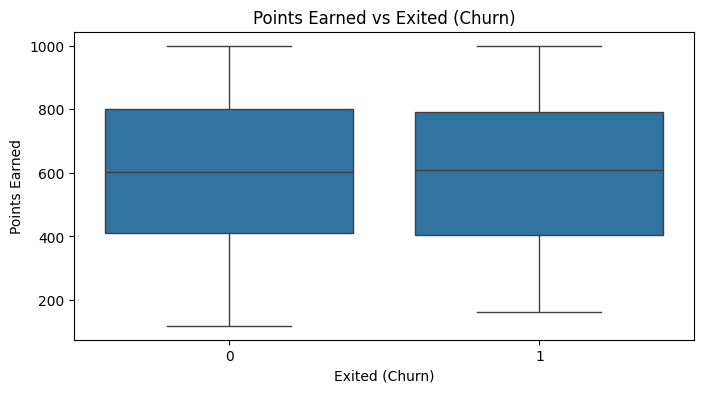

In [62]:
# Loyalty Points Analysis

# Boxplot of Points Earned vs Exited (Churn)
plt.figure(figsize=(8, 4))
sns.boxplot(x='Exited', y='Point Earned', data=df)
plt.title('Points Earned vs Exited (Churn)')
plt.xlabel('Exited (Churn)')
plt.ylabel('Points Earned')
plt.show()

In [64]:
from scipy.stats import ttest_ind

# Separate the data into churned and non-churned groups
churned_points = df[df['Exited'] == 1]['Point Earned']
not_churned_points = df[df['Exited'] == 0]['Point Earned']

# Perform t-test
t_stat, p_value = ttest_ind(churned_points, not_churned_points)
print(f'T-test statistic: {t_stat}')
print(f'P-value: {p_value}')

T-test statistic: -0.4627759848070133
P-value: 0.6435350184288993


#### **Salary Analysis**

Salary and Churn: Analyze the relationship between EstimatedSalary and customer churn, focusing on how financial well-being might influence churn decisions.

In [51]:
# Summary statistics of EstimatedSalary
print(df['EstimatedSalary'].describe())

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64


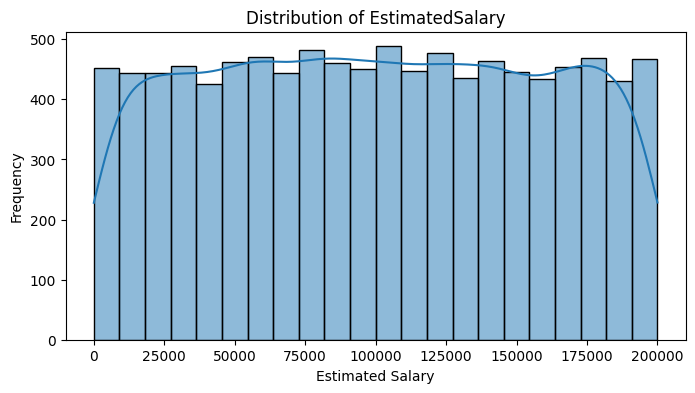

In [55]:
#Histogram of EstimatedSalary

plt.figure(figsize=(8, 4))
sns.histplot(df['EstimatedSalary'], kde=True)
plt.title('Distribution of EstimatedSalary')
plt.xlabel('Estimated Salary')
plt.ylabel('Frequency')
plt.show()

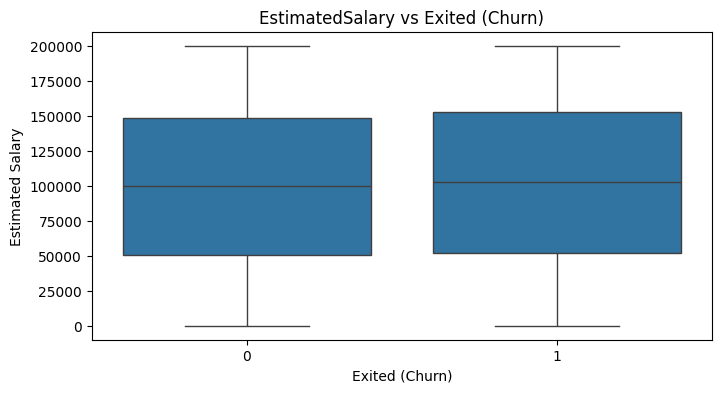

In [57]:
# Boxplot of EstimatedSalary vs Exited (Churn)

plt.figure(figsize=(8, 4))
sns.boxplot(x='Exited', y='EstimatedSalary', data=df)
plt.title('EstimatedSalary vs Exited (Churn)')
plt.xlabel('Exited (Churn)')
plt.ylabel('Estimated Salary')
plt.show()

In [58]:
from scipy.stats import ttest_ind

# Separate the data into churned and non-churned groups
churned = df[df['Exited'] == 1]['EstimatedSalary']
not_churned = df[df['Exited'] == 0]['EstimatedSalary']

# Perform t-test
t_stat, p_value = ttest_ind(churned, not_churned)
print(f'T-test statistic: {t_stat}')
print(f'P-value: {p_value}')

T-test statistic: 1.2489445044833742
P-value: 0.2117146135149097


# **Business Insights:**
1. Gender Disparity: Female customers exhibit a higher churn rate (11.4%) compared to males (9%).
2. Age and Churn: Customers in the 40–50 age group have the highest churn rate (7.9%), with those in the 30–40 age group closely following.
3. Geographic Differences: France and Germany share a higher churn rate (8.1%) than Spain (4.1%).
4. Activity Matters: Inactive members demonstrate a significantly higher churn rate (13%) than active members.
5. Credit Card Impact: Customers with credit cards churn at a notably higher rate (14.2%) than those without (6.1%).
6. Card Type & Churn: Diamond cardholders churn more frequently (5.5%) than those with other card types.
7. Product Usage Paradox: Customers owning at least one product churn at a higher rate (14.1%).
8. Satisfaction Scores: No clear correlation is seen between satisfaction scores and churn.
9. The Complaint Factor: All churned customers have a history of complaints.
10. Similar Age Distributions: Churned and retained customers both concentrate in the 30–50 age range with retained customers slightly skewing younger (30–40).
11. Credit Score Similarity: Churned and retained customers show comparable credit score distributions.
12. Balance Differences: Churned customers’ balances are concentrated lower (40,000–125,000) compared to retained customers.

# **Recommendation**
- The stakeholders should consider creating products that specifically target seniors who are approaching retirement age to prevent them from leaving the bank.
- Additionally, the bank could introduce an incentive program for customers who have maintained a long-standing relationship with the bank. They could also offer an exclusive package consisting of travel and vacation deals, subsidized investment portfolios, etc., to customers who have an account balance of over $200k to reduce the rate at which they leave the bank.

- The bank needs to investigate why there is a 100% churn rate for Prod 2 customers with an account balance of $1k-$10k and find ways to bring them back to the business.
- In summary, the bank should focus on retaining customers in the age group of 51–60, people with low credit scores, and those with high account balances (> $200k). The recommendations mentioned above, along with other effective strategies, should be considered to improve customer retention and reduce the churn rate.